In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [9]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [10]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

# reflect the tables


OperationalError: (sqlite3.OperationalError) unable to open database file
(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [59]:
# View all of the classes that automap found
measurement = Base.classes.measurement
station = Base.classes.station

In [60]:
# Save references to each table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [61]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [62]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [63]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [64]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [65]:
# most recent date
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

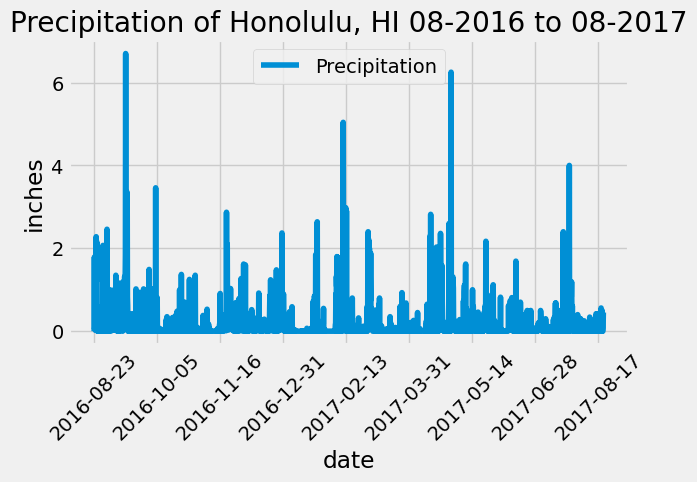

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# List comprehension solution


# Calculate the date one year from the last date in data set.


# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-23").\
    filter(measurement.date <= "2017-08-23").all()

prcp_data    

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data).set_index('date')

prcp_df=prcp_df.rename(columns={'prcp':'Precipitation'})


# Sort the dataframe by date
prcp_df=prcp_df.sort_values(by='date').dropna()
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot(rot=45)
plt.savefig("Precipitation analysis.png")
# prcp_df.plot.bar()
plt.tight_layout()
plt.title("Precipitation of Honolulu, HI 08-2016 to 08-2017")
plt.ylabel("inches")
plt.show()


In [73]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [75]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.id).count()
station_count

9

In [76]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [77]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_number = 'USC00519281'
session.query(func.min(measurement.tobs),
              func.max(measurement.tobs),
              func.avg(measurement.tobs)).filter(measurement.station == station_number).all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'Observed Temp Frequency at Station USC00519281 ')

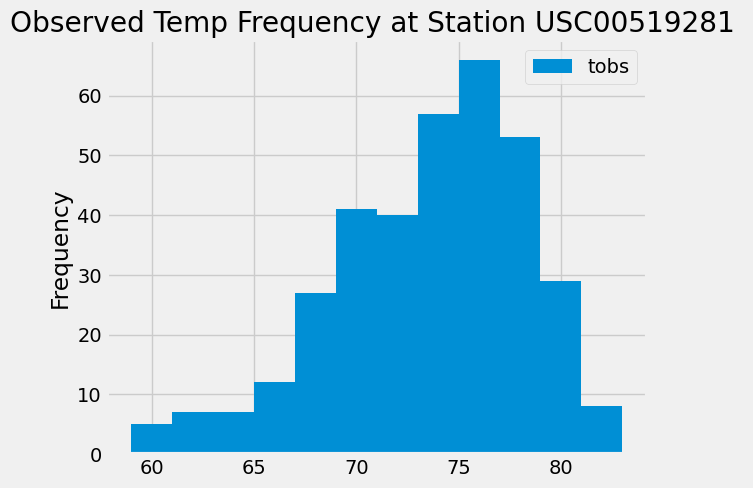

In [91]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_highest_obs = active_stations[0][0]

results = session.query(measurement.date, measurement.tobs).\
                        filter(measurement.date >= "2016-08-23").\
                        filter(measurement.date <= "2017-08-23").\
                        filter(measurement.station == station_highest_obs).all()  
# convert to dataframe
results_df = pd.DataFrame(results)                     

# historgram 

results_df.plot.hist(bins=12)
plt.tight_layout()
plt.title("Observed Temp Frequency at Station USC00519281 ")


# Close session

In [92]:
# Close Session
session.close()

In [94]:
from flask import Flask, jsonify

# 2. Create an app, being sure to pass __name__
app = Flask(__name__)

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"

    )


@app.route("/api/v1.0/precipitation")
def names():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of all passenger names"""
    # Query all passengers
#    prcp_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= "2016-08-23").\
#     filter(measurement.date <= "2017-08-23").all()

#     session.close()

#Query results from prcp analysis
    prcp_analysis = list(np.ravel(prcp_data))

    return jsonify(prcp_analysis)
   


# @app.route("/api/v1.0/passengers")
# def passengers():
#     # Create our session (link) from Python to the DB
#     session = Session(engine)

#     """Return a list of passenger data including the name, age, and sex of each passenger"""
#     # Query all passengers
#     results = session.query(Passenger.name, Passenger.age, Passenger.sex).all()

#     session.close()

#     # Create a dictionary from the row data and append to a list of all_passengers
#     all_passengers = []
#     for name, age, sex in results:
#         passenger_dict = {}
#         passenger_dict["name"] = name
#         passenger_dict["age"] = age
#         passenger_dict["sex"] = sex
#         all_passengers.append(passenger_dict)

#     return jsonify(all_passengers)


# if __name__ == '__main__':
#     app.run(debug=True)
